In [1]:
#| default_exp modules

In [2]:
#| hide
from nbdev.showdoc import *

# modules

> This package contains the modules that make up the [FastSpeech](https://arxiv.org/abs/1905.09263) architecture
![](../assets/fastspeech-architecture.png)

In [3]:
#| export
import torch
import torch.nn as nn
from torch import tensor
import math
from einops import rearrange
import torch.nn.functional as F

In [4]:
#| hide
from fastcore.test import *
import matplotlib.pyplot as plt
import librosa
from fastspeech.visualize import show_mel

In [5]:
#| hide
def get_shape(*args: tensor): return tuple(map(lambda x: x.shape, [*args]))

In [6]:
#| hide

vocab_sz = 50
n_hidden = 48
filter_sz = 64
n_heads = 2
bs = 16
seq_len = 18
out_shape = [bs, seq_len, n_hidden]

In [7]:
#| hide
sample_batch = torch.randint(vocab_sz, (bs, seq_len))
sample_batch.shape

torch.Size([16, 18])

## phoneme embedding
> The first module of the fastspeech architecture is the input embeddings where they embed the input phonemes in to the models hidden dimension

In [8]:
embedding = nn.Embedding(vocab_sz, n_hidden)
samples_embedded = embedding(sample_batch)
samples_embedded.shape

torch.Size([16, 18, 48])

In [9]:
#| hide
test_eq(out_shape, samples_embedded.shape)

## positional embedding
> After the embedding layer in the fastspeech model it inputs positional embedding to allow the model to have information on the positons of inputs. The positional embedding used in the [FastSpeech](https://arxiv.org/abs/1905.09263) paper is the function described in the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper.

In [10]:
#| export
def get_positional_embeddings(seq_len, # The length of the sequence
                              d_model, # The hidden dimension of the model
                              device: torch.device =None): # Device you want to use
    pos = torch.arange(d_model, device=device)[None, :]
    i = torch.arange(seq_len, device=device)[:, None]
    angle = pos / torch.pow(10000, 2 * i / d_model)
    pos_emb = torch.zeros(angle.shape, device=device)
    pos_emb[0::2,:], pos_emb[1::2,:] = angle[0::2,:].sin(), angle[1::2,:].cos()
    return pos_emb

In [11]:
pos_emb = get_positional_embeddings(seq_len, n_hidden)
pos_emb.shape

torch.Size([18, 48])

In [12]:
#| hide
test_eq(pos_emb.shape, [seq_len, n_hidden])

In [13]:
inp = samples_embedded + pos_emb
inp.shape

torch.Size([16, 18, 48])

In [14]:
#| hide
test_eq(inp.shape, out_shape)

## xavier initialization

In [15]:
#| export
class Conv1d(nn.Conv1d):
    ''''''
    def __init__(self, *args, **kwargs):
        ''''''
        super().__init__(*args, **kwargs)
        nn.init.xavier_uniform_(self.weight, nn.init.calculate_gain('linear'))

In [16]:
Conv1d(seq_len, 10, 1)(inp).shape

torch.Size([16, 10, 48])

In [17]:
#| export
class Linear(nn.Linear):
    ''''''
    def __init__(self, *args, **kwargs):
        ''''''
        super().__init__(*args, **kwargs)
        nn.init.xavier_uniform_(self.weight, nn.init.calculate_gain('linear'))

## feed-forward transformer
> This component of the model is the engine of the model. It is what will be used to make up the phoneme encoder and mel spectrogram decoder. It consists of a Multi-Head Attention block and a Conv Network. An additional note from the paper is that prior to the addition of residual inputs and the normalization. ![Scaled Dot Product Attention and Multi-Head Attention](../assets/multi-head-attention.png)

In [18]:
#| export
class MultiHeadAttention(nn.Module):
    '''The Multi-Head Attention component comes from the 
    [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper. 
    For the purpose of simplicity we combine the two parts of the Multi-Headed Attention 
    into one module'''
    def __init__(self, 
                 ni: int, # The input dimension 
                 nh: int): # The number of attention heads
        ''''''
        super().__init__()
        self.nh = nh
        self.scale = math.sqrt(ni / nh)
        self.kqv = Linear(ni, ni*3)
        self.proj = Linear(ni, ni)
        
    def forward(self, inp: tensor):
        x = self.kqv(inp)
        x = rearrange(x, 'n s (h d) -> (n h) s d', h=self.nh)
        
        Q, K, V = torch.chunk(x, 3, dim=-1)
        x = F.softmax(Q @ K.transpose(1,2) / self.scale, dim=-1) @ V
    
        x = rearrange(x, '(n h) s d -> n s (h d)', h=self.nh)
        x = self.proj(x)
        return x

In [19]:
attention = MultiHeadAttention(n_hidden, n_hidden)
ho = attention(inp)
ho.shape

torch.Size([16, 18, 48])

In [20]:
#| hide
test_eq(ho.shape, out_shape)

In [21]:
#| export
class ConvNetwork(nn.Module):
    '''The Convolution network consists of two Conv1D layers with the 
    intermediate dimension being named the filter size.'''
    def __init__(self, 
                 ni: int, # Input dimension 
                 fs: int, # Filter size for intermediate dimension
                 ks: list[int]): # A two element array of kernal sizes
        ''''''
        super().__init__()
        assert len(ks) == 2
        padding = list(map(lambda x: (x - 1) // 2, ks))
        self.layers = nn.ModuleList([Conv1d(ni, fs, ks[0], padding=padding[0]),
                                     Conv1d(fs, ni, ks[1], padding=padding[1])])
        
    def forward(self, inp: tensor):
        x = inp.transpose(1,2)
        for layer in self.layers:
            x = F.relu(layer(x))
        return x.transpose(1,2)

In [22]:
conv_net = ConvNetwork(n_hidden, filter_sz, [9, 1])
ho = conv_net(ho)
ho.shape

torch.Size([16, 18, 48])

In [23]:
#| hide
test_eq(ho.shape, out_shape)

In [24]:
#| export
class FeedForwardTransformer(nn.Module):
    ''''''
    def __init__(self, 
                 ni: int, # Input dimension
                 nh: int, # Number of attention heads
                 fs: int, # Filter size for intermediate dimension
                 ks: list[int], # A two element list of kernal sizes
                 p: list[float]): # A two element list of dropout probabilities
        '''This module consists of a MultiHeadAttention, and ConvNetwork layer with 
        dropout, residuals, and layer normalization being applied after each layer'''
        super().__init__()
        assert len(ks) == 2 and len(p) == 2
        self.layers = nn.ModuleList([MultiHeadAttention(ni, nh), ConvNetwork(ni, fs, ks)])
        self.norms = nn.ModuleList([nn.LayerNorm(ni) for _ in range(2)])
        self.dropouts = nn.ModuleList([nn.Dropout(p[i]) for i in range(2)])
        
    def forward(self, inp: tensor):
        res = inp
        modules = zip(self.layers, self.norms, self.dropouts)
        for layer, norm, dropout in modules:
            x = layer(res)
            x = norm(dropout(x) + res)
            res = x
        return x

In [25]:
fft = FeedForwardTransformer(n_hidden, n_heads, filter_sz, 
                             ks=[9, 1], p=[0.1, 0.1])
ho = fft(inp)
ho.shape

torch.Size([16, 18, 48])

In [26]:
#| hide
test_eq(ho.shape, out_shape)

## duration predictor

In [27]:
#| export
class DurationPredictor(nn.Module):
    '''This module predicts the logarithmic duration length for each phoneme 
    based on the phoneme hidden features. It consists of 2-layer 1D convolutional network 
    with ReLU activation, each followed by the layer normalization and the dropout layer, 
    and an extra linear layer to output a scalar.'''
    def __init__(self, 
                 ni: int, # Input dimension
                 fs: int, # Filter size for intermediate dimension
                 ks: list[int], # A two element list of kernal sizes
                 p: list[float]): # A two element list of dropout probabilities
        ''''''
        super().__init__()
        assert len(ks) == 2 and len(p) == 2
        
        padding = list(map(lambda x: (x - 1) // 2, ks))
        self.layers = nn.ModuleList([Conv1d(ni, fs, ks[0], padding=padding[0]),
                                     Conv1d(fs, ni, ks[1], padding=padding[1])])
        self.norms = nn.ModuleList([nn.BatchNorm1d(sz) for sz in [fs, ni]])
        self.dropouts = nn.ModuleList([nn.Dropout(p[i]) for i in range(2)])
        self.linear = Linear(ni, 1)
    
    def forward(self, hi: tensor):
        x = hi.transpose(1, 2)
        modules = zip(self.layers, self.norms, self.dropouts)
        for layer, norm, dropout in modules:
            x = layer(x)
            x = dropout(F.relu(x))
            x = norm(x)
        x = self.linear(x.transpose(1,2))
        return x.squeeze()

In [28]:
log_durations = DurationPredictor(n_hidden, 32, [3,3], [0.1,0.1])(ho)
log_durations.shape

torch.Size([16, 18])

In [29]:
#| hide
test_eq(log_durations.shape, [bs, seq_len])

## length regulator
> This module upsamples the phoneme hidden feature to the size of the melspectrogram based on the phoneme durations provided

In [30]:
#| export
def length_regulator(hi: tensor, # The hidden phoneme features
                     durations: tensor, # The phoneme durations to upsample to
                     upsample_ratio: float, # The multiplier ratio of upsampling rate
                     device: torch.device = None): # Device you want to use
    assert len(durations.sum(dim=1).unique()) == 1
    durations = (upsample_ratio * durations).to(torch.int)
    
    (bs, _, nh), sl = hi.shape, durations[0].sum().item()
    
    ho = torch.zeros((bs, sl, nh), device=device)
    for i in range(bs):
        ho[i] = hi[i].repeat_interleave(durations[i], dim=0)
    return ho

In [31]:
durations = tensor([[10]*seq_len for i in range(bs)])
ho = length_regulator(ho, durations, 1.)
ho.shape

torch.Size([16, 180, 48])

In [32]:
#| hide
test_eq(ho.shape, [bs, durations[0].sum(), n_hidden])

## postnet
> To help convergence we use a postenet as described in [tacotron 2](https://arxiv.org/abs/1712.05884)

In [58]:
#| export
class PostNet(nn.Module):
    def __init__(self,
                 ni: int, # Input dimension 
                 fs: int, # Filter size for intermediate dimension
                 ks: int,# Kernal size
                 p: float, # Dropout probability
                 nl: int = 5): # The number of convolution layers
        super().__init__()
        padding = (ks - 1) // 2
        self.layers = nn.ModuleList([Conv1d(ni, fs, ks, padding=padding),
                                   *[Conv1d(fs, fs, ks, padding=padding) 
                                       for i in range(nl-2)],
                                     Conv1d(fs, ni, ks, padding=padding)])
        self.norms = nn.ModuleList([*[nn.BatchNorm1d(fs) for i in range(nl-1)],
                                     nn.BatchNorm1d(ni)])
        self.dropout = nn.Dropout(p)
        
    def forward(self, inp):
        x = inp
        
        modules = zip(self.layers, self.norms)
        for i, (layer, norm) in enumerate(modules):
            x = layer(x)
            x = norm(x)
            x = F.tanh(x) if i < len(self.layers) - 1 else x
            x = self.dropout(x)
            
        return x

In [60]:
PostNet(n_hidden, 32, 5, 0.5)(ho.transpose(1,2)).shape

torch.Size([16, 48, 180])

In [61]:
#| export
class Config:
    '''To allow for easily configurable modules we 
    decided to create a Config to allow for more readable, 
    and customizable code when creating modules'''
    def __init__(self, Module, # The module you want to initalize
                 *args, **kwargs): 
        self.Module = Module
        self.args, self.kwargs = [*args], {**kwargs}
    
    def build(self):
        return self.Module(*self.args, **self.kwargs)

## fastspeech
> This is module will contain the full architecture for FastSpeech. it will consists of the feed-forward Transformer block, the length regulator, and the duration predictor.

In [64]:
#| export
class FastSpeech(nn.Module):
    ''''''
    def __init__(self, 
                 ne: int, # Number of embeddings (vocab size) 
                 ni: int, # The number of hidden dimension
                 no: int, # The number of outputs bins (mel bins)
                 encoder_c: Config, # Encoder config 
                 n_e_fft: int, # The number of FFT in encoder
                 decoder_c: Config, # Decoder config
                 n_d_fft: int, # The number of FFT in decoder
                 duration_c: Config, # Duration Predictor config
                 postnet_c: Config,
                 device=None):
        ''''''
        super().__init__()
        self.device = device
        self.embedding = nn.Embedding(ne, ni)
        self.encoder = nn.Sequential(*[encoder_c.build() for _ in range(n_e_fft)])
        self.decoder = nn.Sequential(*[decoder_c.build() for _ in range(n_d_fft)])
        self.duration_predictor = duration_c.build()
        self.linear = Linear(ni, no)
        self.postnet = postnet_c.build()
        
    def forward(self, inp: tensor, # The input phonemes in vectorized form
                durations: tensor = None, # The phoneme durations, used for training
                upsample_ratio: float = 1.): # Upsampling ratio (adjust speed of speech)
        x = self.embedding(inp)
        x = x +  get_positional_embeddings(*x.shape[-2:], device=self.device)
        x = self.encoder(x)

        log_durations = self.duration_predictor(x)
        if durations == None or not self.training:
            durations = log_durations.exp()
        x = length_regulator(x, durations, upsample_ratio, device=self.device)
        
        x = x + get_positional_embeddings(*x.shape[-2:], device=self.device)
        x = self.decoder(x)
        x = self.linear(x).transpose(1,2)
        
        res = self.postnet(x)
        x = (x + res)
        
        x = x
        
        return (x, log_durations, res) if self.training else x        

In [65]:
n_out = 80
encoder_config = Config(FeedForwardTransformer,
                        n_hidden, n_heads, 64, [9,1], [0.1,0.1])
decoder_config = Config(FeedForwardTransformer,
                        n_hidden, n_heads, 64, [3,3], [0.1,0.1])
dp_config = Config(DurationPredictor, n_hidden, 48, [3,3], [0.1, 0.1])

postnet_c = Config(PostNet, n_out, 32, 5, 0.5)

model = FastSpeech(vocab_sz, n_hidden, n_out, encoder_config, 4,
                   decoder_config, 6, dp_config, postnet_c)
with torch.no_grad(): mel, _, _ = model(sample_batch, durations)
mel.shape

torch.Size([16, 80, 180])

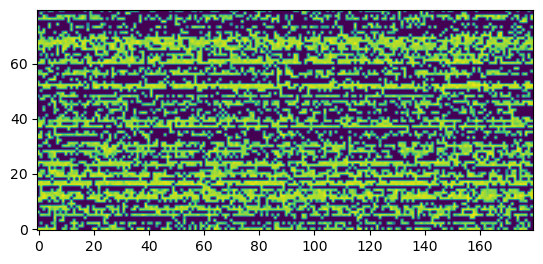

In [53]:
show_mel(mel[0]);

In [39]:
#| hide
import nbdev; nbdev.nbdev_export()